In [589]:
from keras.datasets import mnist
import numpy as np
from sklearn import svm, naive_bayes, neural_network, neighbors, metrics
from sklearn.preprocessing import binarize
from PIL import Image
from joblib import dump, load
import matplotlib.pyplot as plt
%matplotlib inline

# Digit Recognition Experiment 1
In this experiment we will use the well known MNIST dataset to train a simple and fast digit recognizer. Then we will check to see if this trained recognizer can generalize to the kinds of printed digits we will see in the minesweeper cells. 

We start by loading in the data from the large MNIST dataset.

In [623]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /=255

#Flatten Images to single vector (no CNNs here)
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

binarize(X_train, copy=False)
binarize(X_test, copy=False)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [33]:
Image.fromarray((X_train[:4].reshape(28*4,28)*255).astype('uint8'))

## Training Models
We will experiment quickly for 4 different classes of models (SVM, MLP, Naive Bayes and KNN). We will then choose the best performing one (based on accuracy) and use that model for the rest of the experiments. This is mostly here for fun and curiosity.

In [5]:
clfs = [
    ("SVM", svm.SVC()),
    ("MLP", neural_network.MLPClassifier()),
    ("NaiveBayes", naive_bayes.MultinomialNB()),
    ("KNN", neighbors.KNeighborsClassifier(n_neighbors=3))
]

for name, clf in clfs:
    
    clf.fit(X_train[0:10000], y_train[0:10000])
    
    y_pred = clf.predict(X_test)
    
    print(name)
    print("\tConfusion:\n",metrics.confusion_matrix(y_test, y_pred))
    print("\tAccurarcy: ", metrics.accuracy_score(y_test, y_pred))
    dump(clf, '../models/{}_10k.joblib'.format(name))
    

d:\anaconda2\envs\tensorflow\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM
	Confusion:
 [[ 962    0    2    0    1    6    6    1    2    0]
 [   0 1117    2    2    0    2    4    0    8    0]
 [   9    3  920   10   16    2   20   15   34    3]
 [   4    1   22  916    0   29    2   14   17    5]
 [   1    2    5    0  908    1   11    4    2   48]
 [   9    6    5   35   10  790   16    5   12    4]
 [  10    3   10    1   10   14  909    0    1    0]
 [   0   23   25    1   10    1    0  940    5   23]
 [   7    9    7   15   10   31   13    9  859   14]
 [  11    9    3   12   46    7    1   22    6  892]]
	Accurarcy:  0.9213
MLP
	Confusion:
 [[ 962    0    2    1    0    3    8    1    2    1]
 [   0 1119    9    0    0    1    3    0    3    0]
 [   6    0  975    9    5    0    7   12   16    2]
 [   2    3   15  950    2    8    0    6   18    6]
 [   2    2    1    0  945    0    9    1    6   16]
 [   7    1    1   16    3  816   12    4   23    9]
 [   6    3    5    0    9    9  916    2    8    0]
 [   0    8   18    8    5    1    0  980   

We notice that the default MLP did the best, we will just train one on all the data to get our final model. We won't do any hyper-parameter optimization here yet, until we see if it works on the rendered examples.

In [34]:
mlp_clf = neural_network.MLPClassifier()
mlp_clf.fit(X_train, y_train)    
y_pred = mlp_clf.predict(X_test)

print("MLP Final")
print("\tConfusion:\n",metrics.confusion_matrix(y_test, y_pred))
print("\tAccurarcy: ", metrics.accuracy_score(y_test, y_pred))
dump(clf, '../models/MLP_60k.joblib')

MLP Final
	Confusion:
 [[ 971    0    1    1    0    2    2    0    1    2]
 [   0 1121    4    1    1    0    2    0    6    0]
 [   6    1 1009    2    1    1    1    5    5    1]
 [   0    1    2  979    1    9    0    4    8    6]
 [   2    1    3    1  943    1    4    1    4   22]
 [   2    1    0    6    1  864    6    1    8    3]
 [   5    2    2    1    2    2  939    1    4    0]
 [   0    3   10    3    3    0    0  996    5    8]
 [   6    2    5   10    3    7    1    5  932    3]
 [   2    4    1    9    9    5    1    7    8  963]]
	Accurarcy:  0.9717


['../models/MLP_60k.joblib']

## Domain Verification
Now we check to see of the network trained on handwritten digits can generalize to the new domain we have of computer generated numbers

Looks like with the right image preprocessing, a network trained on the MNIST dataset can work with our digit recognition


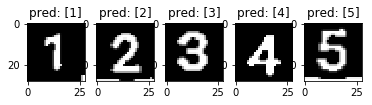

In [677]:
import cv2
clf = load('../models/MLP_60k.joblib')

def getImage(path):    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)    
    img = cv2.GaussianBlur(img,(5,5),0)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3)    
    img = np.invert(img)
    img = cv2.resize(img, (28, 28))     
    img = img.reshape(-1, 784)    
    img = img.astype('float32')   
    img /= 255
    return img


tests = [getImage('../resources/{}.png'.format(x)) for x in range(1,6)]
f, axarr = plt.subplots(1,5)
for i in range(5):
    axarr[i].imshow((tests[i].reshape(28,28)*255).astype('uint8'), cmap='gray')
    axarr[i].set_title("pred: {}".format(clf.predict(tests[i])))

print("Looks like with the right image preprocessing, a network trained on the MNIST dataset can work with our digit recognition")

# Digit Recognition Experiment 2
After analyzing some of the source code for the game (cryptic minified JS) there are some color codes were were able to extract out for the font.
```
"#1976D2 #388E3C #D32F2F #7B1FA2 #FF8F00 #0097A7 #424242 #9E9E9E"
```
Here we see if these color codes can be used to identify the number in a cell grid, by doing simple histogram matching.

In [816]:
background_colors = [(229,193,161), (215,183,155), (136,174,70), (171,213,94),  (163, 207, 86)]
unclickable = [(229,193,161), (215,183,155)]
clickable = [(171,213,94),  (163, 207, 86)]

def hex_to_rgb(h):
    if "#" in h:
        h = h.lstrip("#")
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(r):
    return "#{:02x}{:02x}{:02x}".format(int(r[0]), int(r[1]), int(r[2]))

# rgbs = [hex_to_rgb(x) for x in "#1976D2 #388E3C #D32F2F #7B1FA2 #FF8F00 #0097A7 ".split()] # #424242 #9E9E9E
rgbs = [(27,121,206), (63,142,69), (210,51,54), (134,54,158), (254,146,0)]
lab = np.zeros((len(rgbs),1,3), dtype='uint8')
for i in range(len(rgbs)):
    lab[i] = rgbs[i]
lab = cv2.cvtColor(lab, cv2.COLOR_RGB2LAB)

def renderGrid(cells):
    images, rows,cols, chans = cells.shape
    img = np.zeros((14*rows, 18*cols, chans))
    for i,cell in enumerate(cells):        
        y,x= (int(i%14)*rows,int(i%14)*rows+rows), (int(i/14)*cols,int(i/14)*cols+cols)         
        img[y[0]:y[1], x[0]:x[1], :] = cell
    return img.astype('uint8')


image = cv2.imread('../resources/sample_grids/sample_3.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_grid = np.linspace(0, image.shape[1], num=18, endpoint=False)
y_grid = np.linspace(0, image.shape[0], num=14, endpoint=False)
cell_w, cell_h = (int(image.shape[1]/18), int(image.shape[0]/14))

cells = []
for x in x_grid:
    for y in y_grid:
        dx, dy = int(x), int(y)
        cells.append(image[dy:dy+cell_h, dx:dx+cell_w].copy())       

cells = np.stack(cells)

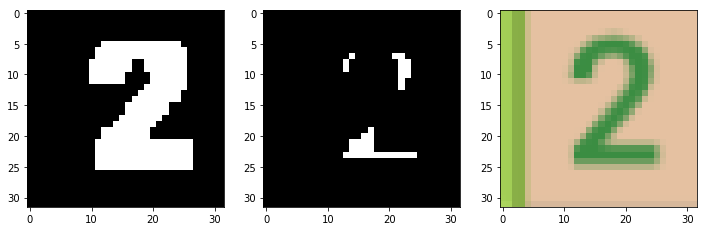

In [814]:
def getMaskedCells(cells, background_colors):
    final_mask = np.zeros(cells.shape[:-1])   
    for color in background_colors:        
        final_mask = np.logical_or(np.all(cells == color, axis=-1), final_mask)
    border = np.ones(final_mask.shape).astype('bool')
    border[:,5:-5,5:-5] = False
    final_mask = np.logical_or(final_mask, border)
    return np.invert(final_mask)

mask = getMaskedCells(cells, background_colors).astype('uint8')[224]
erroded_mask = cv2.erode(mask, None, iterations=2)

f, axarr = plt.subplots(1,3, figsize=(12,8))
axarr[0].imshow(mask,cmap='gray')
axarr[1].imshow(erroded_mask, cmap='gray')
axarr[2].imshow(cells[224])
plt.show()

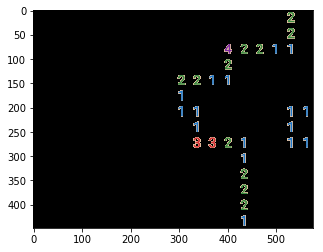

In [700]:
cell_masks = getMaskedCells(cells, background_colors)

masked_cells = cells * cell_masks[...,None]
plt.imshow(renderGrid(masked_cells))

Text(0.5, 1.0, 'Raw Image of Grid State')

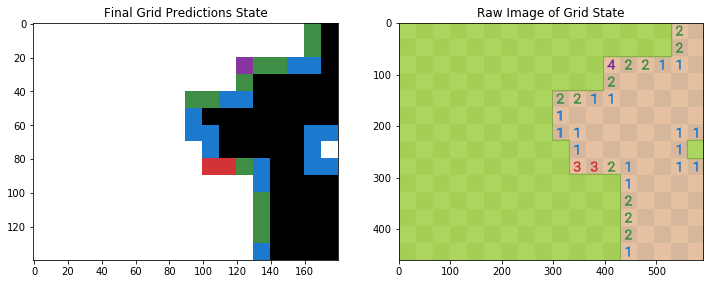

In [701]:
from scipy.spatial import distance as dist
mean_image = []

def getClosestColor(mean, colors):
    minDist = (np.inf, None)        
    for i, col in enumerate(colors):
        d = dist.euclidean(np.array(col), mean)
        if d < minDist[0]:
            minDist = (d,i) 
            
    return minDist

for cell, mask in zip(cells, cell_masks):  
    lab_img = cv2.cvtColor(cell, cv2.COLOR_RGB2LAB)
    mean = cv2.mean(cell, mask = mask.astype('uint8'))[:3]
   
    if np.sum(mask) > 50:
        minDist = getClosestColor(mean, rgbs)
        mean_img = np.zeros((10,10,3))
        mean_img[...,:3]= rgbs[minDist[1]]
        mean_image.append(mean_img)
    else:
        mean = cv2.mean(cell)[:3]        
        minDist = getClosestColor(mean, clickable + unclickable)            
        if minDist[1]<=1:            
            mean_img = np.zeros((10,10,3))
            mean_img[...,:3] = (255,255,255)            
            mean_image.append(mean_img)
        else:
            mean_img = np.zeros((10,10,3))        
            mean_image.append(mean_img)

mean_image = np.stack(mean_image)
f, axarr = plt.subplots(1,2, figsize=(12,8))
axarr[0].imshow(renderGrid(mean_image))
axarr[0].set_title("Final Grid Predictions State")
axarr[1].imshow(image)
axarr[1].set_title("Raw Image of Grid State")

# Final Method
We have explored 2 methods for recognizing the elements on the minesweeper grid. The standard machine learning approach worked quite well in recognizing the digits. The color matching method, requires some hand tuning but proved quite successful in determining the final state of the grid. For the final method, we will explore using the machine learning approach for digit recognition, and the color matching for detecting clickable and unclickable cells.

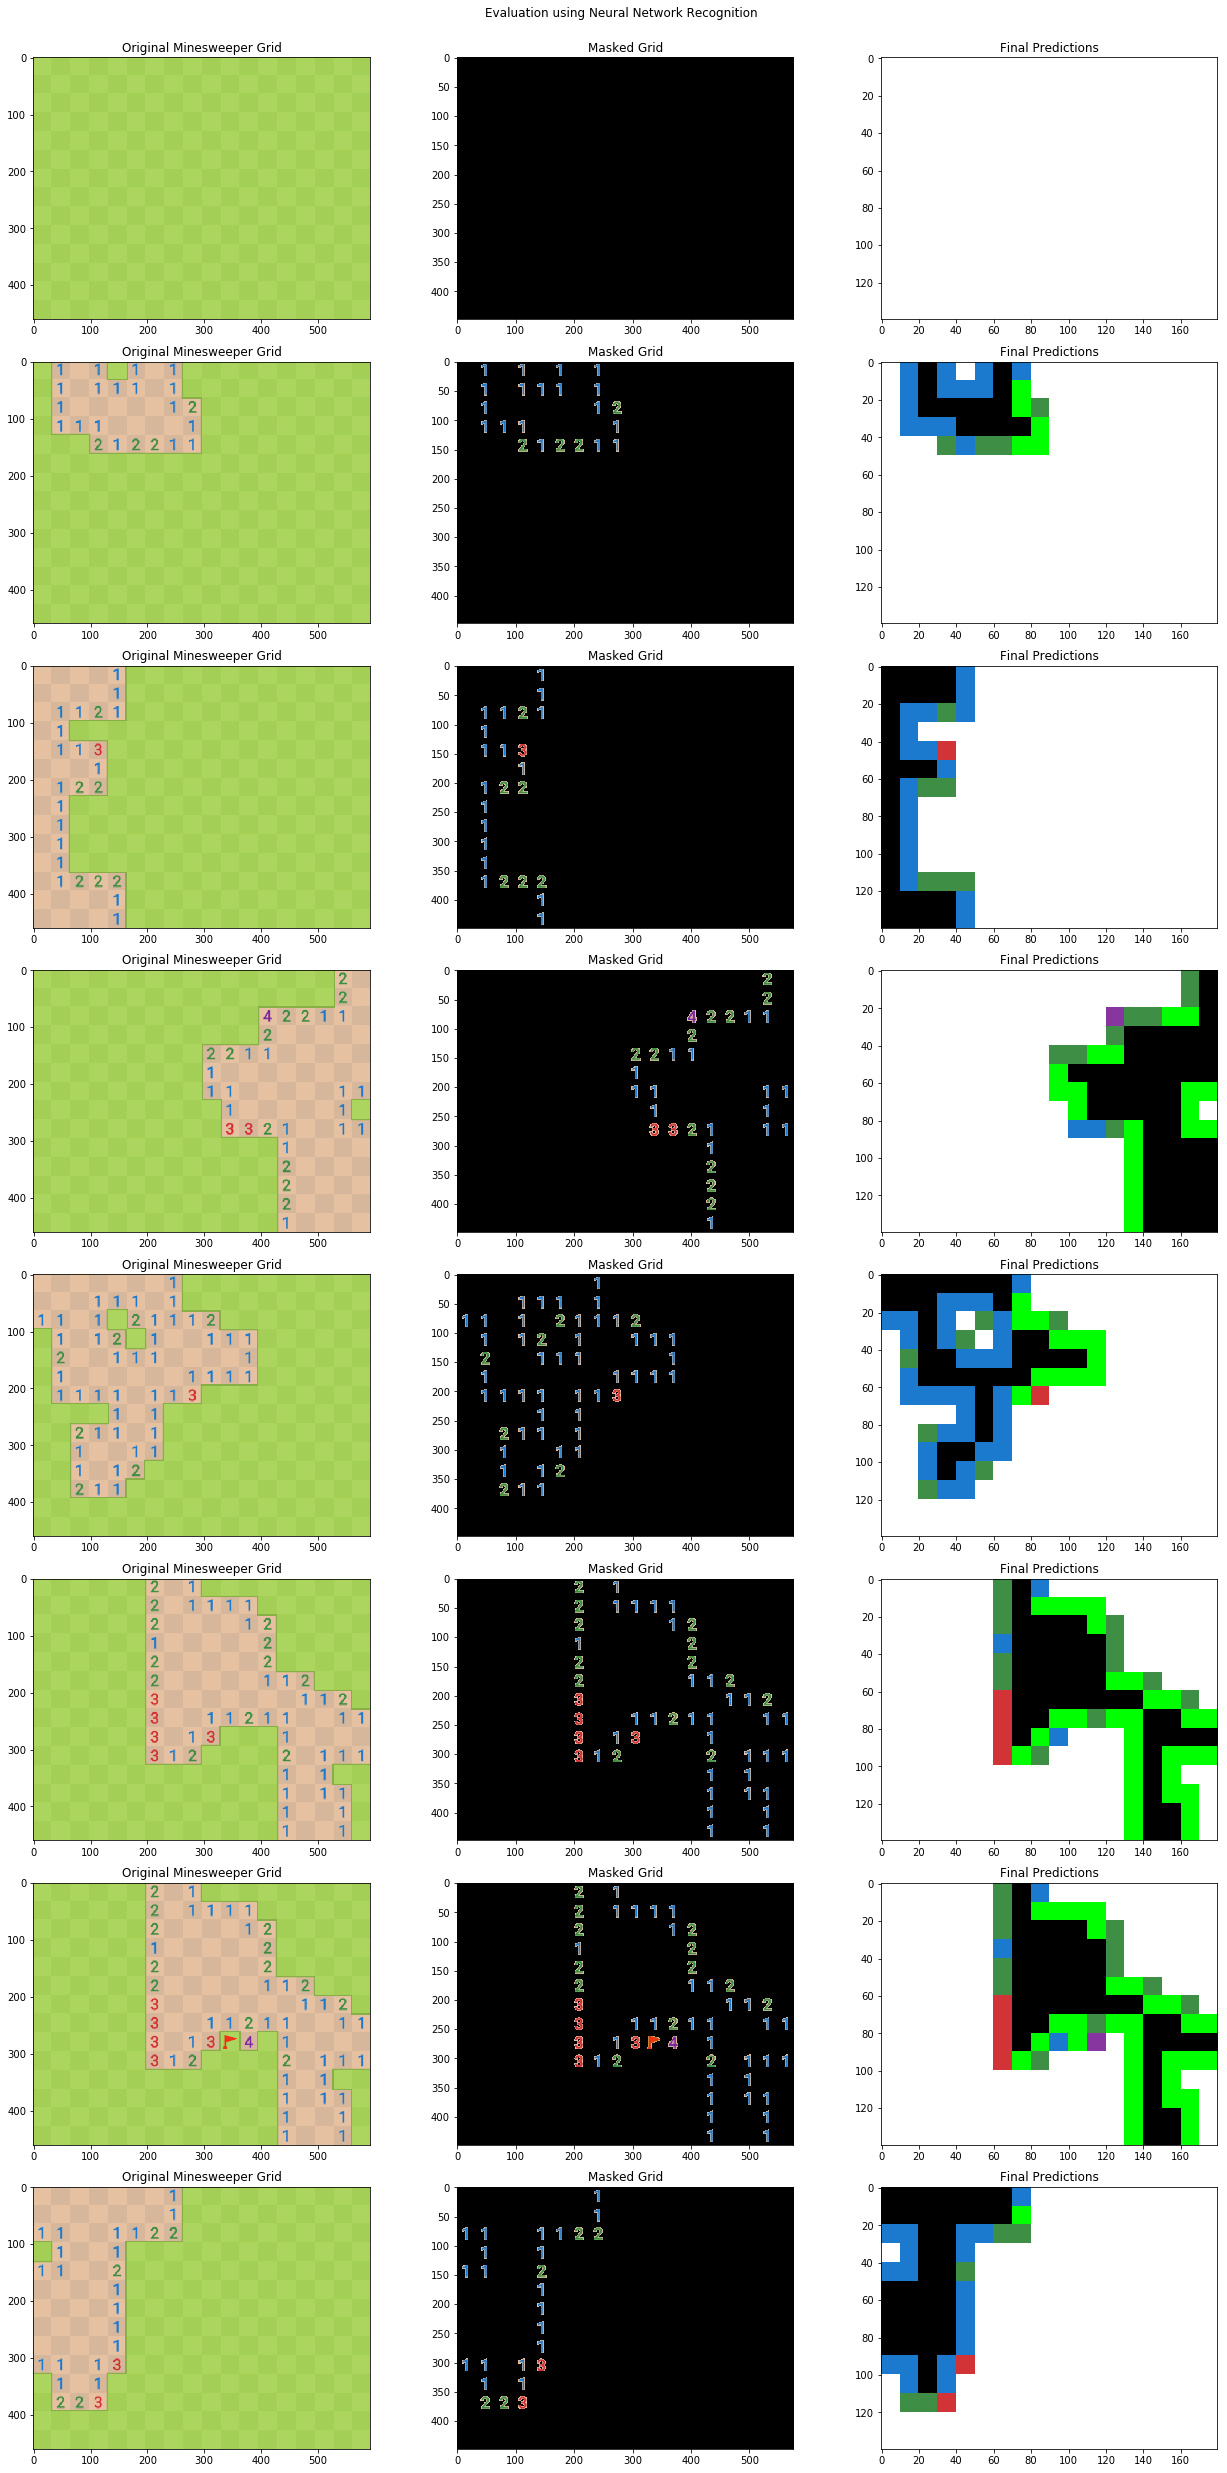

In [854]:
def evaluateMethod(use_neural=True):
    results = []
    for i in range(0,8):
        image = cv2.imread('../resources/sample_grids/sample_{}.png'.format(i))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x_grid = np.linspace(0, image.shape[1], num=18, endpoint=False)
        y_grid = np.linspace(0, image.shape[0], num=14, endpoint=False)
        cell_w, cell_h = (int(image.shape[1]/18), int(image.shape[0]/14))

        cells = []
        for x in x_grid:
            for y in y_grid:
                dx, dy = int(x), int(y)
                cells.append(image[dy:dy+cell_h, dx:dx+cell_w].copy())       

        cells = np.stack(cells)
        cell_masks = getMaskedCells(cells, background_colors)
        masked_cells = cells * cell_masks[...,None]

        predictions = []
        net_images = []
        for cell, mask in zip(cells, cell_masks):
            mean = cv2.mean(cell, mask = mask.astype('uint8'))[:3]

            if np.sum(mean) > 50:
                if use_neural:
                    p=2
                    img = cv2.cvtColor(cell, cv2.COLOR_RGB2GRAY)  
                    img = np.pad(img[p:-p,p:-p], pad_width=((p,p),(p,p)), mode='constant', constant_values=0)
                    img = cv2.GaussianBlur(img,(5,5),0)        
                    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3)    
                    img = np.invert(img)
                    img = cv2.resize(img, (28, 28))     
                    net_images.append(img)
                    img = img.reshape(-1, 784)    
                    img = img.astype('float32')   
                    img /= 255      

                    pred = np.argmax(clf.predict_proba(img)[:,1:8])        
                    predictions.append(pred)
                else:
                    minDist = getClosestColor(mean, rgbs)
                    predictions.append(minDist[1])
            else:
                mean = cv2.mean(cell)[:3]        
                minDist = getClosestColor(mean, clickable + unclickable)            
                if minDist[1]<=1:            
                    predictions.append(-1)
                else:
                    predictions.append(-2)   

        prediction_image = []
        for prediction in predictions:
            if prediction in [0,1,2,3,4]:
                img = np.zeros((10,10,3))
                img[...,:3] = rgbs[prediction]           
                prediction_image.append(img)
            elif prediction == -1:
                img = np.zeros((10,10,3))
                img[...,:3] = (255,255,255)     
                prediction_image.append(img)
            elif prediction == -2:
                img = np.zeros((10,10,3))        
                prediction_image.append(img)
            else:
                img = np.zeros((10,10,3))  
                img[...,:3] = (0,255,0) 
                prediction_image.append(img)

        prediction_image = np.stack(prediction_image) 
        results.append((image, masked_cells, prediction_image))
    return results

results = evaluateMethod(use_neural=True)
f, axarr = plt.subplots(len(results),3, figsize=(18,35))
f.suptitle("Evaluation using Neural Network Recognition")
for i, (image, masked_cells, prediction_image) in enumerate(results):
    axarr[i,0].imshow(image)
    axarr[i,0].set_title("Original Minesweeper Grid")
    axarr[i,1].imshow(renderGrid(masked_cells))
    axarr[i,1].set_title("Masked Grid")
    axarr[i,2].imshow(renderGrid(prediction_image))
    axarr[i,2].set_title("Final Predictions")

f.tight_layout()
f.subplots_adjust(top=0.96)

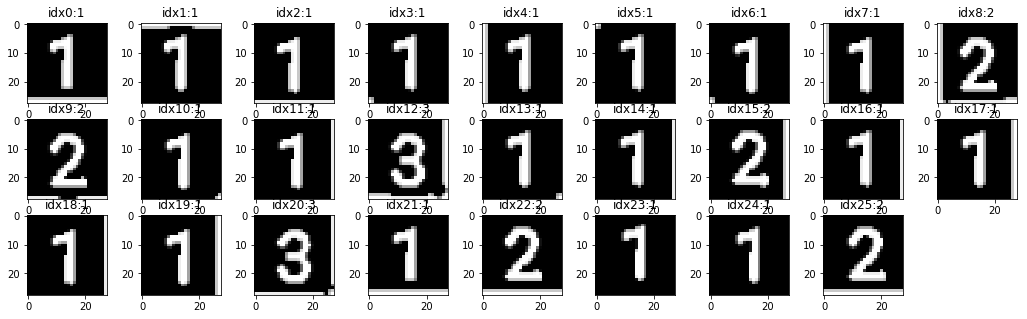

In [840]:
fig = plt.figure(figsize=(18,5))

for i,net in enumerate(net_images):
    ax1 = fig.add_subplot(3,len(net_images)/3 +1,i+1)
    
    p =3
    img = net#np.pad(net[p:-p,p:-p], pad_width=((p,p),(p,p)), mode='constant', constant_values=0)
    
    ax1.imshow(img, cmap='gray')
    
    
    img = img.reshape(-1, 784)    
    img = img.astype('float32')   
    img /= 255   
    ax1.set_title("idx{}:{}".format(i,np.argmax(clf.predict_proba(img)[:,1:6])+1))

plt.show()

## Hmmmm second thoughts
Seems like the current neural network method doesn't do so well when we let it predict against all the possible digits. Lets use the color matching method for now :(. The neural network method can be improved by potentially training a better classifier (CNNs) on computer generated text rather than hand written ones.

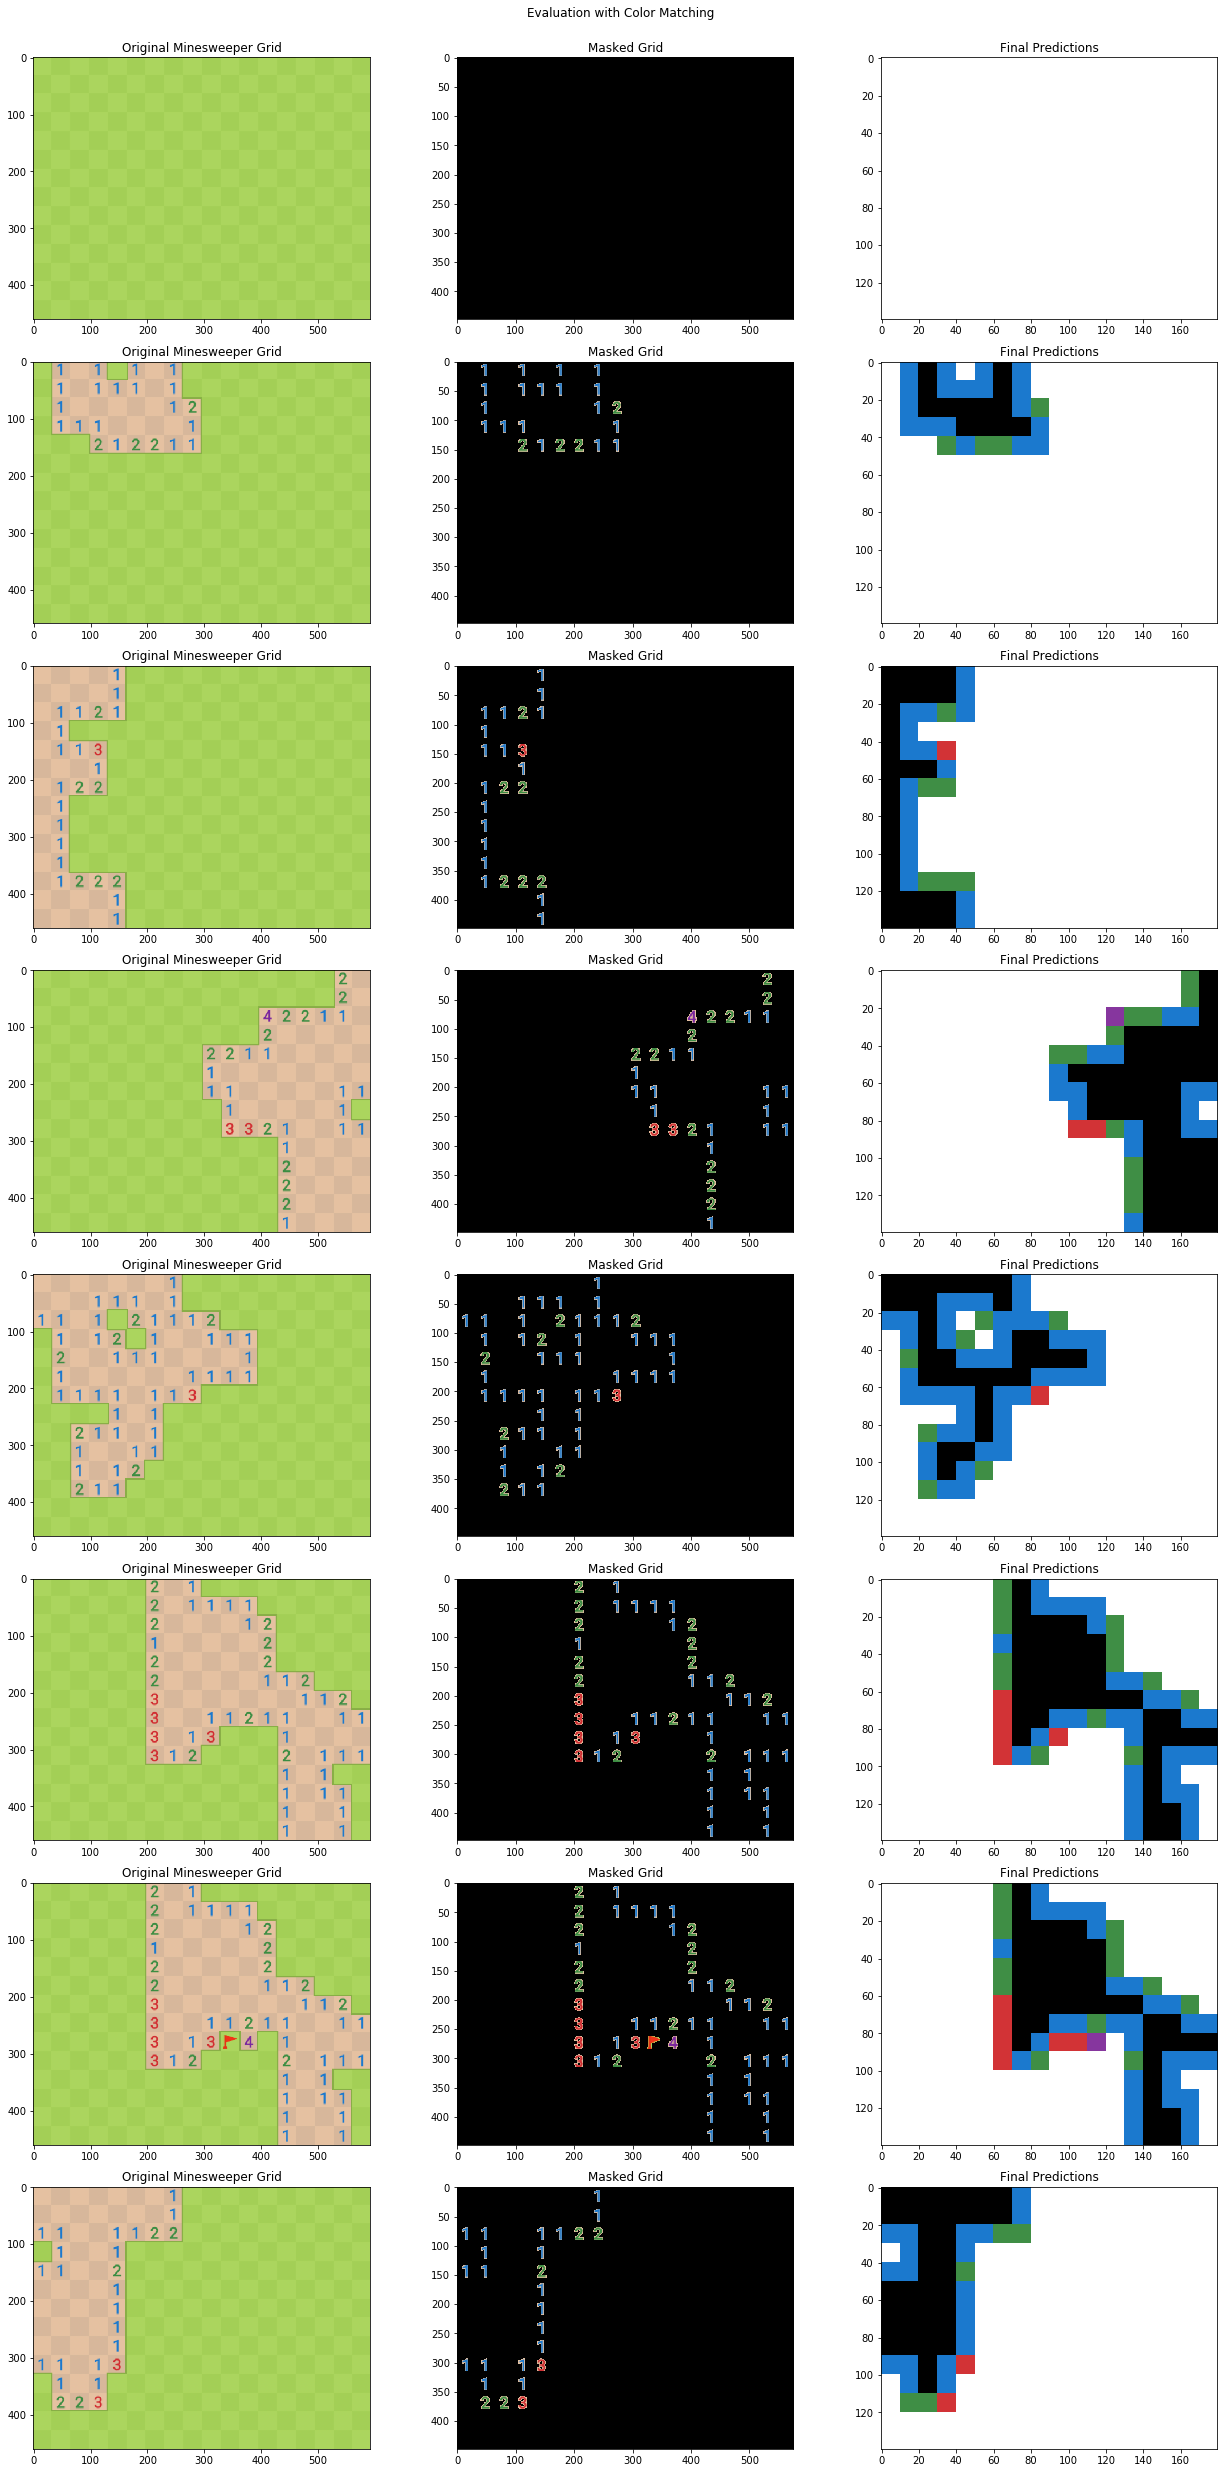

In [856]:
results = evaluateMethod(use_neural=False)
f, axarr = plt.subplots(len(results),3, figsize=(18,35))
f.suptitle("Evaluation with Color Matching")
for i, (image, masked_cells, prediction_image) in enumerate(results):
    axarr[i,0].imshow(image)
    axarr[i,0].set_title("Original Minesweeper Grid")
    axarr[i,1].imshow(renderGrid(masked_cells))
    axarr[i,1].set_title("Masked Grid")
    axarr[i,2].imshow(renderGrid(prediction_image))
    axarr[i,2].set_title("Final Predictions")

f.tight_layout()
f.subplots_adjust(top=0.96)

# Conclusions
Ultimately we ended up going with the color matching solution for identifying the minesweeper board. The method is faster, and works very well in identifying the number 1 through 5. 